# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [118]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from scipy.stats import multinomial

In [37]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [38]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [45]:
X, y = read_dataset("spam")

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [94]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
        self.classes = ['spam', 'ham']
    
    def fit(self, X, y):
        df = pd.DataFrame(X)
        df['y'] = y
        X_true = df[df['y'] == 'spam'].drop('y', axis=1)
        X_false = df[df['y'] == 'ham'].drop('y', axis=1)
        self.params_true = []
        sum_true, sum_false = 0, 0
        self.params_false = []
        for column in X_true.columns:
            self.params_true.append(sum(X_true[column]))
            sum_true += sum(X_true[column])
        self.params_true = (np.array(self.params_true) + self.alpha)/(sum_true + len(X_true.columns)*self.alpha)
        for column in X_false.columns:
            self.params_false.append(sum(X_false[column]))
            sum_false += sum(X_false[column])
        self.params_false = (np.array(self.params_false) + self.alpha)/(sum_false + len(X_false.columns)*self.alpha)
        self.p = len(X_true)/len(X)
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        probs = []
        for x in X:
            prob = []
            n = sum(x)
            rv_true = multinomial(n, self.params_true)
            rv_false = multinomial(n, self.params_false)
            prob.append(np.log(self.p) + rv_true.logpmf(x))
            prob.append(np.log(1 - self.p) + rv_false.logpmf(x))
            probs.append(prob)
        return probs

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [130]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        self.voc = {}
        for text in X:
            string = text.split()
            for word in string:
                if word in self.voc:
                    self.voc[word] += 1
                else:
                    self.voc[word] = 1
        self.voc = list(dict(sorted(self.voc.items(), key=lambda x: x[1], reverse=True)[:voc_limit-2]).keys())        
    def transform(self, X):
        data = []
        for text in X:
            features = []
            digits = ['0', '1', '2', '3', '4', '5',
                     '6', '7', '8', '9']
            special = ['$', '+', '£', '₤', '€']
            number_special = [0, 0]
            for symbol in text:
                number_special[0] += 1 if symbol in digits else 0
                number_special[1] += 1 if symbol in special else 0
            words = Counter(text.split())
            for word in self.voc:
                features.append(words[word])
            features.extend(number_special)
            data.append(features)
        return data

In [135]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [136]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.989517819706499, 'spam': 0.8024691358024691},
 {'ham': 0.9672131147540983, 'spam': 0.9285714285714286},
 0.9623655913978495)

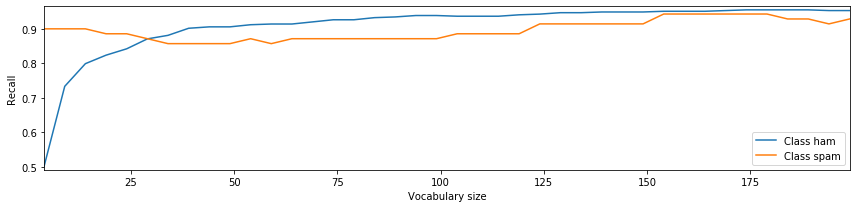

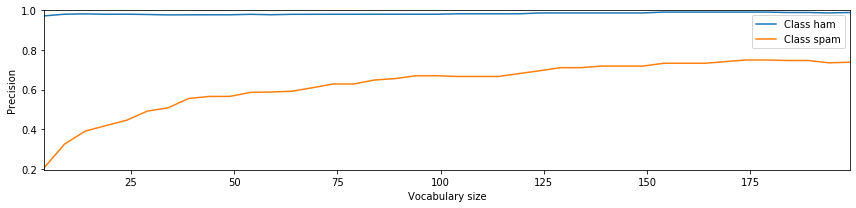

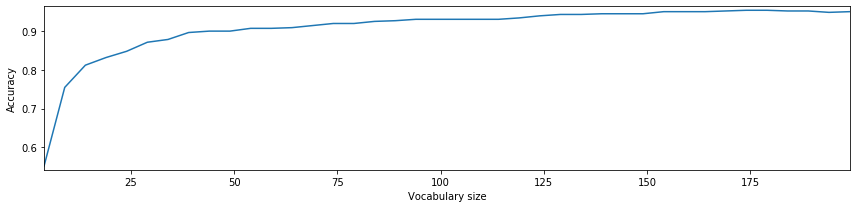

In [137]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [146]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        sno = SnowballStemmer(language='english')
        self.voc = {}
        for text in X:
            string = text.split()
            for word in string:
                word = sno.stem(word)
                if word in self.voc:
                    self.voc[word] += 1
                else:
                    self.voc[word] = 1
        self.voc = list(dict(sorted(self.voc.items(), key=lambda x: x[1], reverse=True)[:voc_limit-2]).keys())        
    def transform(self, X):
        sno = SnowballStemmer(language='english')
        data = []
        for text in X:
            features = []
            digits = ['0', '1', '2', '3', '4', '5',
                     '6', '7', '8', '9']
            special = ['$', '+', '£', '₤', '€']
            number_special = [0, 0]
            for symbol in text:
                number_special[0] += 1 if symbol in digits else 0
                number_special[1] += 1 if symbol in special else 0
            w = text.split()
            for index, word in enumerate(w):
                w[index] = sno.stem(word)
            words = Counter(w)
            for word in self.voc:
                features.append(words[word])
            features.extend(number_special)
            data.append(features)
        return data

In [147]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [148]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9917184265010351, 'spam': 0.88},
 {'ham': 0.9815573770491803, 'spam': 0.9428571428571428},
 0.9767025089605734)

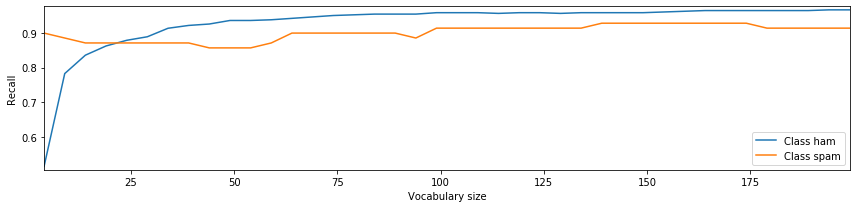

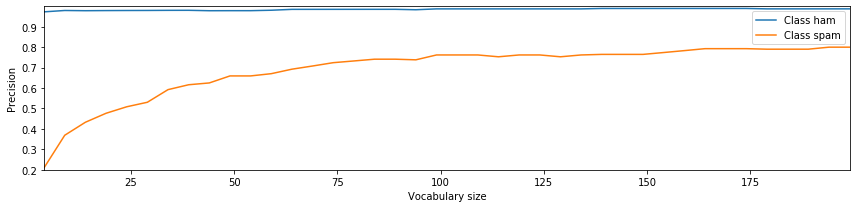

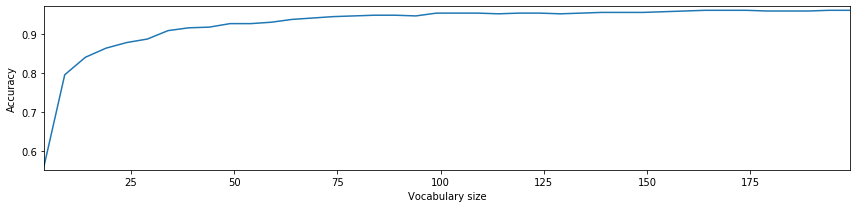

In [149]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)